<a href="https://colab.research.google.com/github/jun9729/denoise-Cnn/blob/main/%08MPR_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive._mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import zipfile
import tqdm
from PIL import Image
from tqdm import tqdm

file_name = "Multimedia_dataset.zip"
zip_path = os.path.join('/content/drive/MyDrive/lab/Multimedia_dataset.zip')

!cp "{zip_path}" .
!unzip -q "{file_name}"
!rm "{file_name}"

In [2]:
import torch
from torch.autograd import Variable
from torchvision import transforms

import random

class NoiseTransform(object):
  def __init__(self, size=180, mode="training"):
    super(NoiseTransform, self).__init__()
    self.size = size
    self.mode = mode
  
  def gaussian_noise(self, img):
    mean = 0
    stddev = 25
    noise = Variable(torch.zeros(img.size()))
    noise = noise.data.normal_(mean, stddev/255.)

    return noise

  def __call__(self, img):
    if (self.mode == "training") | (self.mode == "validation"):
      self.gt_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor()])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.gt_transform(img), self.noise_transform(img)

    elif self.mode == "testing":
      self.gt_transform = transforms.Compose([
        # transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor()])
      return self.gt_transform(img)
    else:
      return NotImplementedError


In [3]:
import torch
import torch.utils.data  as data
import os
from PIL import Image

class NoiseDataset(data.Dataset):
  def __init__(self, root_path, size):
    super(NoiseDataset, self).__init__()

    self.root_path = root_path
    self.size = size
    self.transforms = None
    self.examples = None

  def set_mode(self, mode):
    self.mode = mode
    self.transforms = NoiseTransform(self.size, mode)
    if mode == "training":
      train_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(train_dir)]
    elif mode == "validation":
      val_dir = os.path.join(self.root_path, "validation")
      self.examples = [os.path.join(self.root_path, "validation", dirs) for dirs in os.listdir(val_dir)]
    elif mode == "testing":
      test_dir = os.path.join(self.root_path, "test")
      self.examples = [os.path.join(self.root_path, "test", dirs) for dirs in os.listdir(test_dir)]
    else:
      raise NotImplementedError
  
  def __len__(self):
    return len(self.examples)

  def __getitem__(self, idx):
    file_name = self.examples[idx]
    image = Image.open(file_name)

    if self.mode == "testing":
      input_img = self.transforms(image)
      sample = {"img": input_img}
    else:
      clean, noise = self.transforms(image)
      sample = {"img": clean, "noise": noise}

    return sample

  0%|          | 0/563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


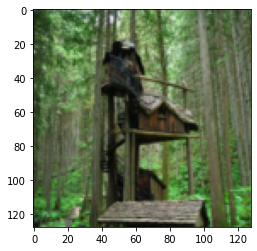

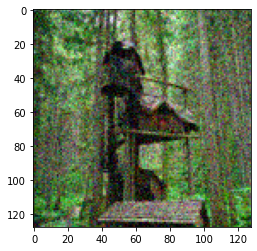

 17%|█▋        | 98/563 [00:06<00:18, 24.89it/s]

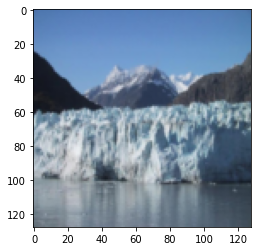

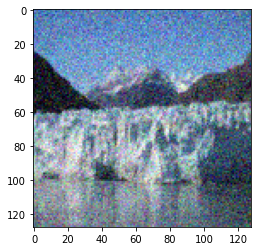

 35%|███▌      | 198/563 [00:10<00:13, 27.31it/s]

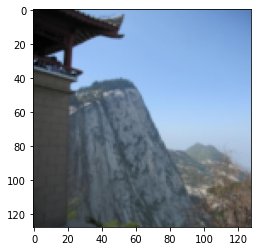

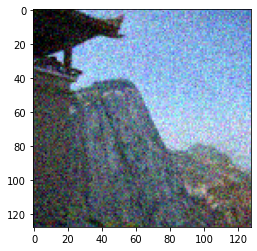

 53%|█████▎    | 300/563 [00:15<00:09, 27.56it/s]

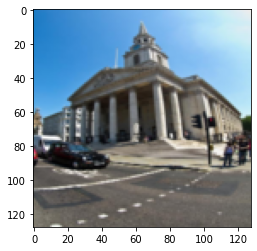

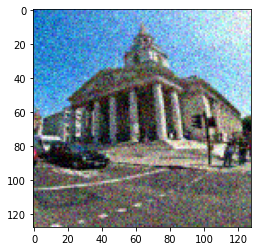

 71%|███████   | 399/563 [00:19<00:05, 27.84it/s]

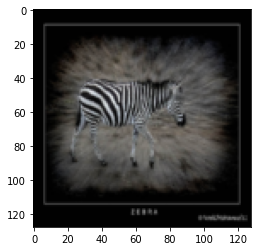

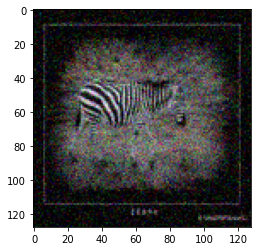

 88%|████████▊ | 498/563 [00:23<00:02, 28.28it/s]

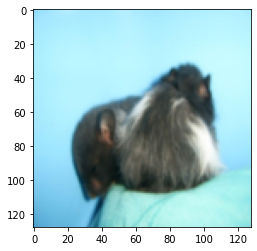

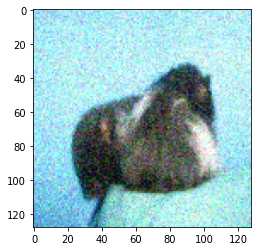

100%|██████████| 563/563 [00:25<00:00, 21.78it/s]


In [4]:
import torch
import torch.utils.data  as data
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
from PIL import Image

def image_show(img):
  if isinstance(img, torch.Tensor):
    img = transforms.ToPILImage()(img)
  plt.imshow(img)
  plt.show()

# Change to your data root directory
root_path = "/content/"
# Depend on runtime setting
use_cuda = True

train_dataset = NoiseDataset(root_path, 128)
train_dataset.set_mode("training")

train_dataloader = data.DataLoader(train_dataset, batch_size=8, shuffle=True)

for i, data in enumerate(tqdm.tqdm(train_dataloader)):
  if use_cuda:
    img = data["img"].to('cuda')
    noise = data["noise"].to('cuda')
  
  model_input = img + noise
  noise_image = torch.clamp(model_input, 0, 1)


  if i % 100 == 0:
    image_show(img[0])
    image_show(noise_image[0])



In [5]:
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from torch.autograd import Variable
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
from torchsummary import summary

##########################################################################
def conv(in_channels, out_channels, kernel_size, bias=False, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride = stride)


##########################################################################
## Channel Attention Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, bias=False):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=bias),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=bias),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y


##########################################################################
## Channel Attention Block (CAB)
class CAB(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, bias, act):
        super(CAB, self).__init__()
        modules_body = []
        modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
        modules_body.append(act)
        modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))

        self.CA = CALayer(n_feat, reduction, bias=bias)
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res = self.CA(res)
        res += x
        return res

##########################################################################
## Supervised Attention Module
class SAM(nn.Module):
    def __init__(self, n_feat, kernel_size, bias):
        super(SAM, self).__init__()
        self.conv1 = conv(n_feat, n_feat, kernel_size, bias=bias)
        self.conv2 = conv(n_feat, 3, kernel_size, bias=bias)
        self.conv3 = conv(3, n_feat, kernel_size, bias=bias)

    def forward(self, x, x_img):
        x1 = self.conv1(x)
        img = self.conv2(x) + x_img
        x2 = torch.sigmoid(self.conv3(img))
        x1 = x1*x2
        x1 = x1+x
        return x1, img

##########################################################################
## U-Net

class Encoder(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff):
        super(Encoder, self).__init__()

        self.encoder_level1 = [CAB(n_feat,                     kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.encoder_level2 = [CAB(n_feat+scale_unetfeats,     kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.encoder_level3 = [CAB(n_feat+(scale_unetfeats*2), kernel_size, reduction, bias=bias, act=act) for _ in range(2)]

        self.encoder_level1 = nn.Sequential(*self.encoder_level1)
        self.encoder_level2 = nn.Sequential(*self.encoder_level2)
        self.encoder_level3 = nn.Sequential(*self.encoder_level3)

        self.down12  = DownSample(n_feat, scale_unetfeats)
        self.down23  = DownSample(n_feat+scale_unetfeats, scale_unetfeats)

        # Cross Stage Feature Fusion (CSFF)
        if csff:
            self.csff_enc1 = nn.Conv2d(n_feat,                     n_feat,                     kernel_size=1, bias=bias)
            self.csff_enc2 = nn.Conv2d(n_feat+scale_unetfeats,     n_feat+scale_unetfeats,     kernel_size=1, bias=bias)
            self.csff_enc3 = nn.Conv2d(n_feat+(scale_unetfeats*2), n_feat+(scale_unetfeats*2), kernel_size=1, bias=bias)

            self.csff_dec1 = nn.Conv2d(n_feat,                     n_feat,                     kernel_size=1, bias=bias)
            self.csff_dec2 = nn.Conv2d(n_feat+scale_unetfeats,     n_feat+scale_unetfeats,     kernel_size=1, bias=bias)
            self.csff_dec3 = nn.Conv2d(n_feat+(scale_unetfeats*2), n_feat+(scale_unetfeats*2), kernel_size=1, bias=bias)

    def forward(self, x, encoder_outs=None, decoder_outs=None):
        enc1 = self.encoder_level1(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc1 = enc1 + self.csff_enc1(encoder_outs[0]) + self.csff_dec1(decoder_outs[0])

        x = self.down12(enc1)

        enc2 = self.encoder_level2(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc2 = enc2 + self.csff_enc2(encoder_outs[1]) + self.csff_dec2(decoder_outs[1])

        x = self.down23(enc2)

        enc3 = self.encoder_level3(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc3 = enc3 + self.csff_enc3(encoder_outs[2]) + self.csff_dec3(decoder_outs[2])
        
        return [enc1, enc2, enc3]

class Decoder(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, scale_unetfeats):
        super(Decoder, self).__init__()

        self.decoder_level1 = [CAB(n_feat,                     kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.decoder_level2 = [CAB(n_feat+scale_unetfeats,     kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.decoder_level3 = [CAB(n_feat+(scale_unetfeats*2), kernel_size, reduction, bias=bias, act=act) for _ in range(2)]

        self.decoder_level1 = nn.Sequential(*self.decoder_level1)
        self.decoder_level2 = nn.Sequential(*self.decoder_level2)
        self.decoder_level3 = nn.Sequential(*self.decoder_level3)

        self.skip_attn1 = CAB(n_feat,                 kernel_size, reduction, bias=bias, act=act)
        self.skip_attn2 = CAB(n_feat+scale_unetfeats, kernel_size, reduction, bias=bias, act=act)

        self.up21  = SkipUpSample(n_feat, scale_unetfeats)
        self.up32  = SkipUpSample(n_feat+scale_unetfeats, scale_unetfeats)

    def forward(self, outs):
        enc1, enc2, enc3 = outs
        dec3 = self.decoder_level3(enc3)

        x = self.up32(dec3, self.skip_attn2(enc2))
        dec2 = self.decoder_level2(x)

        x = self.up21(dec2, self.skip_attn1(enc1))
        dec1 = self.decoder_level1(x)

        return [dec1,dec2,dec3]

##########################################################################
##---------- Resizing Modules ----------    
class DownSample(nn.Module):
    def __init__(self, in_channels,s_factor):
        super(DownSample, self).__init__()
        self.down = nn.Sequential(nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False),
                                  nn.Conv2d(in_channels, in_channels+s_factor, 1, stride=1, padding=0, bias=False))

    def forward(self, x):
        x = self.down(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels,s_factor):
        super(UpSample, self).__init__()
        self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                nn.Conv2d(in_channels+s_factor, in_channels, 1, stride=1, padding=0, bias=False))

    def forward(self, x):
        x = self.up(x)
        return x

class SkipUpSample(nn.Module):
    def __init__(self, in_channels,s_factor):
        super(SkipUpSample, self).__init__()
        self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                nn.Conv2d(in_channels+s_factor, in_channels, 1, stride=1, padding=0, bias=False))

    def forward(self, x, y):
        x = self.up(x)
        x = x + y
        return x

##########################################################################
## Original Resolution Block (ORB)
class ORB(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, num_cab):
        super(ORB, self).__init__()
        modules_body = []
        modules_body = [CAB(n_feat, kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

##########################################################################
class ORSNet(nn.Module):
    def __init__(self, n_feat, scale_orsnetfeats, kernel_size, reduction, act, bias, scale_unetfeats, num_cab):
        super(ORSNet, self).__init__()

        self.orb1 = ORB(n_feat+scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)
        self.orb2 = ORB(n_feat+scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)
        self.orb3 = ORB(n_feat+scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)

        self.up_enc1 = UpSample(n_feat, scale_unetfeats)
        self.up_dec1 = UpSample(n_feat, scale_unetfeats)

        self.up_enc2 = nn.Sequential(UpSample(n_feat+scale_unetfeats, scale_unetfeats), UpSample(n_feat, scale_unetfeats))
        self.up_dec2 = nn.Sequential(UpSample(n_feat+scale_unetfeats, scale_unetfeats), UpSample(n_feat, scale_unetfeats))

        self.conv_enc1 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_enc2 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_enc3 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)

        self.conv_dec1 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_dec2 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_dec3 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)

    def forward(self, x, encoder_outs, decoder_outs):
        x = self.orb1(x)
        x = x + self.conv_enc1(encoder_outs[0]) + self.conv_dec1(decoder_outs[0])

        x = self.orb2(x)
        x = x + self.conv_enc2(self.up_enc1(encoder_outs[1])) + self.conv_dec2(self.up_dec1(decoder_outs[1]))

        x = self.orb3(x)
        x = x + self.conv_enc3(self.up_enc2(encoder_outs[2])) + self.conv_dec3(self.up_dec2(decoder_outs[2]))

        return x


##########################################################################
class MPRNet(nn.Module):
    def __init__(self, in_c=3, out_c=3, n_feat=80, scale_unetfeats=48, scale_orsnetfeats=32, num_cab=8, kernel_size=3, reduction=4, bias=False):
        super(MPRNet, self).__init__()

        act=nn.PReLU()
        self.shallow_feat1 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))
        self.shallow_feat2 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))
        self.shallow_feat3 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))

        # Cross Stage Feature Fusion (CSFF)
        self.stage1_encoder = Encoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=False)
        self.stage1_decoder = Decoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats)

        self.stage2_encoder = Encoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=True)
        self.stage2_decoder = Decoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats)

        self.stage3_orsnet = ORSNet(n_feat, scale_orsnetfeats, kernel_size, reduction, act, bias, scale_unetfeats, num_cab)

        self.sam12 = SAM(n_feat, kernel_size=1, bias=bias)
        self.sam23 = SAM(n_feat, kernel_size=1, bias=bias)
        
        self.concat12  = conv(n_feat*2, n_feat, kernel_size, bias=bias)
        self.concat23  = conv(n_feat*2, n_feat+scale_orsnetfeats, kernel_size, bias=bias)
        self.tail     = conv(n_feat+scale_orsnetfeats, out_c, kernel_size, bias=bias)

    def forward(self, x3_img):
        # Original-resolution Image for Stage 3
        H = x3_img.size(2)
        W = x3_img.size(3)

        # Multi-Patch Hierarchy: Split Image into four non-overlapping patches

        # Two Patches for Stage 2
        x2top_img  = x3_img[:,:,0:int(H/2),:]
        x2bot_img  = x3_img[:,:,int(H/2):H,:]

        # Four Patches for Stage 1
        x1ltop_img = x2top_img[:,:,:,0:int(W/2)]
        x1rtop_img = x2top_img[:,:,:,int(W/2):W]
        x1lbot_img = x2bot_img[:,:,:,0:int(W/2)]
        x1rbot_img = x2bot_img[:,:,:,int(W/2):W]

        ##-------------------------------------------
        ##-------------- Stage 1---------------------
        ##-------------------------------------------
        ## Compute Shallow Features
        x1ltop = self.shallow_feat1(x1ltop_img)
        x1rtop = self.shallow_feat1(x1rtop_img)
        x1lbot = self.shallow_feat1(x1lbot_img)
        x1rbot = self.shallow_feat1(x1rbot_img)
        
        ## Process features of all 4 patches with Encoder of Stage 1
        feat1_ltop = self.stage1_encoder(x1ltop)
        feat1_rtop = self.stage1_encoder(x1rtop)
        feat1_lbot = self.stage1_encoder(x1lbot)
        feat1_rbot = self.stage1_encoder(x1rbot)
        
        ## Concat deep features
        feat1_top = [torch.cat((k,v), 3) for k,v in zip(feat1_ltop,feat1_rtop)]
        feat1_bot = [torch.cat((k,v), 3) for k,v in zip(feat1_lbot,feat1_rbot)]
        
        ## Pass features through Decoder of Stage 1
        res1_top = self.stage1_decoder(feat1_top)
        res1_bot = self.stage1_decoder(feat1_bot)

        ## Apply Supervised Attention Module (SAM)
        x2top_samfeats, stage1_img_top = self.sam12(res1_top[0], x2top_img)
        x2bot_samfeats, stage1_img_bot = self.sam12(res1_bot[0], x2bot_img)

        ## Output image at Stage 1
        stage1_img = torch.cat([stage1_img_top, stage1_img_bot],2) 
        ##-------------------------------------------
        ##-------------- Stage 2---------------------
        ##-------------------------------------------
        ## Compute Shallow Features
        x2top  = self.shallow_feat2(x2top_img)
        x2bot  = self.shallow_feat2(x2bot_img)

        ## Concatenate SAM features of Stage 1 with shallow features of Stage 2
        x2top_cat = self.concat12(torch.cat([x2top, x2top_samfeats], 1))
        x2bot_cat = self.concat12(torch.cat([x2bot, x2bot_samfeats], 1))

        ## Process features of both patches with Encoder of Stage 2
        feat2_top = self.stage2_encoder(x2top_cat, feat1_top, res1_top)
        feat2_bot = self.stage2_encoder(x2bot_cat, feat1_bot, res1_bot)

        ## Concat deep features
        feat2 = [torch.cat((k,v), 2) for k,v in zip(feat2_top,feat2_bot)]

        ## Pass features through Decoder of Stage 2
        res2 = self.stage2_decoder(feat2)

        ## Apply SAM
        x3_samfeats, stage2_img = self.sam23(res2[0], x3_img)


        ##-------------------------------------------
        ##-------------- Stage 3---------------------
        ##-------------------------------------------
        ## Compute Shallow Features
        x3     = self.shallow_feat3(x3_img)

        ## Concatenate SAM features of Stage 2 with shallow features of Stage 3
        x3_cat = self.concat23(torch.cat([x3, x3_samfeats], 1))
        
        x3_cat = self.stage3_orsnet(x3_cat, feat2, res2)

        stage3_img = self.tail(x3_cat)

        return [stage3_img+x3_img, stage2_img, stage1_img]

class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps*self.eps)))
        return loss

class EdgeLoss(nn.Module):
    def __init__(self):
        super(EdgeLoss, self).__init__()
        k = torch.Tensor([[.05, .25, .4, .25, .05]])
        self.kernel = torch.matmul(k.t(),k).unsqueeze(0).repeat(3,1,1,1)
        if torch.cuda.is_available():
            self.kernel = self.kernel.cuda()
        self.loss = CharbonnierLoss()

    def conv_gauss(self, img):
        n_channels, _, kw, kh = self.kernel.shape
        img = F.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
        return F.conv2d(img, self.kernel, groups=n_channels)

    def laplacian_kernel(self, current):
        filtered    = self.conv_gauss(current)    # filter
        down        = filtered[:,:,::2,::2]               # downsample
        new_filter  = torch.zeros_like(filtered)
        new_filter[:,:,::2,::2] = down*4                  # upsample
        filtered    = self.conv_gauss(new_filter) # filter
        diff = current - filtered
        return diff

    def forward(self, x, y):
        loss = self.loss(self.laplacian_kernel(x), self.laplacian_kernel(y))
        return loss

In [12]:
import math

model = MPRNet().cuda() 

# loss 정의
# fn_loss = nn.BCEWithLogitsLoss().cuda()
fn_loss = CharbonnierLoss()

# Optimizer 정의
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-8)

In [13]:
def remove_noise(model, image): # 노이즈 이미지 - model output 이미지 계산 함수
    out = torch.clamp(image - model(image), 0., 1.)
    # out = image - model(image)
    out = out.cpu().clone()
    out = out.squeeze(0)
    trans = transforms.ToPILImage()
    plt.imshow(trans(out))
    plt.show()

def img_show(image): # 노이즈 이미지 - model output 이미지 계산 함수
    out = torch.clamp(image, 0., 1.)
    # out = image
    out = out.cpu().clone()
    out = out.squeeze(0)
    trans = transforms.ToPILImage()
    plt.imshow(trans(out))
    plt.show()

In [14]:
!pip install scikit-image==0.17.2
from skimage.measure.simple_metrics import compare_psnr
def batch_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = 0
    for i in range(Img.shape[0]):
        PSNR += compare_psnr(Iclean[i, :, :, :], Img[i, :, :, :], data_range=data_range)
    return (PSNR/Img.shape[0])

ts = transforms.ToPILImage() # tensor 배열을 이미지로 변환
def train(epoch): # epoch 만큼 학습 반복
    epoch_loss = 0
    for iteration, data in enumerate(train_dataloader, 1):


        model.train()
        model.zero_grad()
        optimizer.zero_grad()

        target = data["img"] #target = 원본 사진
        noise = data["noise"] #노이즈만 있는 사진
        model_input = target + noise


        noise = Variable(noise.cuda())
        target = Variable(target.cuda())
        model_input = Variable(model_input.cuda())

        output = model(model_input)
        psnr_train = batch_PSNR(output[0],target, 1.)
        loss = np.sum([fn_loss(torch.clamp(output[j],0,1),target) for j in range(len(output))])
        # loss = MSE(output, target) 
        epoch_loss += loss.item() 


        loss.backward()
        optimizer.step()


        if iteration % 500 == 0:

          # remove_noise(model,model_input[0].view([-1, 3, 128, 128]).cuda())
          img_show(output[0][0].view([-1, 3, 128, 128]).cuda())
          # img_show(output[1][0].view([-1, 3, 128, 128]).cuda())
          img_show(target[0].view([-1, 3, 128, 128]).cuda())
          img_show(model_input[0].view([-1, 3, 128, 128]).cuda())

          # img_show(output[0].view([-1, 3, 128, 128]).cuda())

          print("Epoch[{}]({}/{}): Loss: {:.4f} : psnr {}".format(epoch, iteration, len(train_dataloader), loss.item(), psnr_train))

    print("Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(train_dataloader)))

In [15]:
def save_checkpoint(state): #epoch 마다 모델 저장
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
num_epochs = 1000
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 1 == 0:
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })